```bash
git clone https://github.com/pytorch/TensorRT.git
cd TensorRT
git checkout remotes/origin/release/1.4
patch -p1 < TensorRT.patch # see below cell
cd /usr/local/include
sudo ln -sf ../../include/math.h .
sudo ln -sf ../../include/stdlib.h .
cd -
bazel build //:libtorchtrt --compilation_mode opt --platforms //toolchains:jetpack_5.0 --spawn_strategy=standalone --verbose_failures
cd py
python setup.py bdist_wheel --release
```

TensorRT.patch

```diff
diff --git a/WORKSPACE b/WORKSPACE
index 2ceb3bd04..bee37a4db 100644
--- a/WORKSPACE
+++ b/WORKSPACE
@@ -31,61 +31,11 @@ git_repository(
     shallow_since = "1570114335 -0400",
 )
 
-# External dependency for torch_tensorrt if you already have precompiled binaries.
-local_repository(
-    name = "torch_tensorrt",
-    path = "/opt/conda/lib/python3.8/site-packages/torch_tensorrt",
-)
-
 # CUDA should be installed on the system locally
 new_local_repository(
     name = "cuda",
     build_file = "@//third_party/cuda:BUILD",
-    path = "/usr/local/cuda-11.8/",
-)
-
-#############################################################################################################
-# Tarballs and fetched dependencies (default - use in cases when building from precompiled bin and tarballs)
-#############################################################################################################
-
-http_archive(
-    name = "libtorch",
-    build_file = "@//third_party/libtorch:BUILD",
-    sha256 = "843ad19e769a189758fd6a21bfced9024494b52344f4bc4fb75f75d36e6ea0c7",
-    strip_prefix = "libtorch",
-    urls = ["https://download.pytorch.org/libtorch/cu118/libtorch-cxx11-abi-shared-with-deps-2.0.1%2Bcu118.zip"],
-)
-
-http_archive(
-    name = "libtorch_pre_cxx11_abi",
-    build_file = "@//third_party/libtorch:BUILD",
-    sha256 = "668a5816ee588e5d96be4803cbbd34263314197cbbb320f43ad25a8c626c02e1",
-    strip_prefix = "libtorch",
-    urls = ["https://download.pytorch.org/libtorch/cu118/libtorch-shared-with-deps-2.0.1%2Bcu118.zip"],
-)
-
-# Download these tarballs manually from the NVIDIA website
-# Either place them in the distdir directory in third_party and use the --distdir flag
-# or modify the urls to "file:///<PATH TO TARBALL>/<TARBALL NAME>.tar.gz
-
-http_archive(
-    name = "cudnn",
-    build_file = "@//third_party/cudnn/archive:BUILD",
-    sha256 = "36fff137153ef73e6ee10bfb07f4381240a86fb9fb78ce372414b528cbab2293",
-    strip_prefix = "cudnn-linux-x86_64-8.8.0.121_cuda11-archive",
-    urls = [
-        "https://developer.download.nvidia.com/compute/cudnn/secure/8.8.0/local_installers/11.8/cudnn-linux-x86_64-8.8.0.121_cuda11-archive.tar.xz",
-    ],
-)
-
-http_archive(
-    name = "tensorrt",
-    build_file = "@//third_party/tensorrt/archive:BUILD",
-    sha256 = "15bfe6053d45feec45ecc7123a9106076b0b43fa0435f242d89dca0778337759",
-    strip_prefix = "TensorRT-8.6.1.6",
-    urls = [
-        "https://developer.nvidia.com/downloads/compute/machine-learning/tensorrt/secure/8.6.1/tars/TensorRT-8.6.1.6.Linux.x86_64-gnu.cuda-11.8.tar.gz",
-    ],
+    path = "/usr/local/cuda-11.4/",
 )
 
 ####################################################################################
@@ -99,29 +49,29 @@ http_archive(
 # x86_64 python distribution. If using NVIDIA's version just point to the root of the package
 # for both versions here and do not use --config=pre-cxx11-abi
 
-#new_local_repository(
-#    name = "libtorch",
-#    path = "/usr/local/lib/python3.6/dist-packages/torch",
-#    build_file = "third_party/libtorch/BUILD"
-#)
-
-#new_local_repository(
-#    name = "libtorch_pre_cxx11_abi",
-#    path = "/usr/local/lib/python3.6/dist-packages/torch",
-#    build_file = "third_party/libtorch/BUILD"
-#)
-
-#new_local_repository(
-#    name = "cudnn",
-#    path = "/usr/",
-#    build_file = "@//third_party/cudnn/local:BUILD"
-#)
-
-#new_local_repository(
-#   name = "tensorrt",
-#   path = "/usr/",
-#   build_file = "@//third_party/tensorrt/local:BUILD"
-#)
+new_local_repository(
+   name = "libtorch",
+   path = "/home/loongson/miniforge3/envs/torch/lib/python3.8/site-packages/torch",
+   build_file = "third_party/libtorch/BUILD"
+)
+
+new_local_repository(
+   name = "libtorch_pre_cxx11_abi",
+   path = "/home/loongson/miniforge3/envs/torch/lib/python3.8/site-packages/torch",
+   build_file = "third_party/libtorch/BUILD"
+)
+
+new_local_repository(
+   name = "cudnn",
+   path = "/usr/",
+   build_file = "@//third_party/cudnn/local:BUILD"
+)
+
+new_local_repository(
+  name = "tensorrt",
+  path = "/usr/",
+  build_file = "@//third_party/tensorrt/local:BUILD"
+)
 
 #########################################################################
 # Development Dependencies (optional - comment out on aarch64)
diff --git a/py/setup.py b/py/setup.py
index 7e44695cf..14cf9906a 100644
--- a/py/setup.py
+++ b/py/setup.py
@@ -25,9 +25,9 @@ from versions import (
 
 dir_path = os.path.dirname(os.path.realpath(__file__))
 
-CXX11_ABI = False
+CXX11_ABI = True
 
-JETPACK_VERSION = None
+JETPACK_VERSION = "5.0"
 
 FX_ONLY = False
 

```

# [Resnet50-example.ipynb](https://colab.research.google.com/github/pytorch/TensorRT/blob/main/notebooks/Resnet50-example.ipynb)

In [ ]:
import torch
import timm
import torch_tensorrt

In [ ]:
name = 'resnet50'
model = timm.create_model(name, pretrained=True)
model = model.eval().to("cuda")

<a id="3"></a>
### Convert to Torch TRT

Torch-TensorRT is a compiler which converts Torchscript graphs into TensorRT helping to levergae the inference optimizations on NVIDIA GPUs. Unlike PyTorch's Just-In-Time (JIT) compiler, Torch-TensorRT is an Ahead-of-Time (AOT) compiler, meaning that before you deploy your TorchScript code, you go through an explicit compile step to convert a standard TorchScript program into a module targeting TensorRT engine. With just one line of code, it provides a simple API that gives a performance speedup on NVIDIA GPUs. 

Let us convert the above FP32 Mobilenetv2 into a TensorRT engine. Before we do that, we need to first export our model to TorchScript. To learn more about Torchscript, please refer to https://pytorch.org/docs/stable/jit.html. The model will then be evaluated and benchmarked for performance so we can compare these numbers against the quantized int8 model later. 

In [ ]:
# Exporting to TorchScript
with torch.no_grad():
    traced_model = torch.jit.trace(model, torch.randn((1,3,224,224)).to("cuda"))

In [ ]:
compile_spec = { # spec for GPU
    "inputs": [torch_tensorrt.Input(
        [1, 3, 224, 224],
        # dtype=torch.half,
    )],
    "enabled_precisions": {torch.float, torch.half},
}

In [ ]:
compile_spec = { # spec for DLA
    "inputs": [torch_tensorrt.Input(
        [1, 3, 224, 224],
        dtype=torch.half,
    )],
    "enabled_precisions": {torch.half},
    "device": torch_tensorrt.Device("dla:0", allow_gpu_fallback=True),
}

In [ ]:
trt_model = torch_tensorrt.compile(traced_model, **compile_spec)

In [ ]:
spec = { # spec for GPU
    "forward": torch_tensorrt.ts.TensorRTCompileSpec(
        **{
            "inputs": [torch_tensorrt.Input([1, 3, 224, 224])],
            "enabled_precisions": {torch.half},
            "device": {
                "device_type": torch_tensorrt.DeviceType.GPU,
                "gpu_id": 0,
            },
            "capability": torch_tensorrt.EngineCapability.default,
            "num_avg_timing_iters": 1,
            "refit": False,
            "debug": False,
        }
    )
}
trt_model = torch._C._jit_to_backend("tensorrt", traced_model, spec)

In [ ]:
spec = { # spec for DLA
    "forward": torch_tensorrt.ts.TensorRTCompileSpec(
        **{
            "inputs": [torch_tensorrt.Input([1, 3, 224, 224])],
            "enabled_precisions": {torch.half},
            "device": {
                "device_type": torch_tensorrt.DeviceType.DLA,
                "gpu_id": 0,
                "dla_core": 0,
                "allow_gpu_fallback": True,
            },
            "capability": torch_tensorrt.EngineCapability.default,
            "num_avg_timing_iters": 1,
            "refit": False,
            "debug": False,
        }
    )
}
trt_model = torch._C._jit_to_backend("tensorrt", traced_model, spec)

# [qat-ptq-workflow.ipynb](https://colab.research.google.com/github/pytorch/TensorRT/blob/main/notebooks/qat-ptq-workflow.ipynb)

In [ ]:
def evaluate(model, dataloader):
    total = 0
    correct = 0
    model.eval()
    scale = 50000//len(dataloader)
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.cuda(), labels.cuda(non_blocking=True)
            out = model(data)
            preds = torch.max(out, 1)[1]
            total += labels.size(0)
            labels = labels * scale + (15 if scale == 50 else 0)
            correct += (preds == labels).sum().item()

    return correct / total

import numpy as np
import time

def benchmark(model, input_shape=(1, 3, 224, 224), dtype='fp32', nwarmup=50, nruns=1000):
    input_data = torch.randn(input_shape)
    input_data = input_data.to("cuda")
    if dtype=='fp16':
        input_data = input_data.half()

    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            pred_loc  = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%100==0:
                print('Iteration %d/%d, avg batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_data.size())
    print('Average throughput: %.2f images/second'%(input_shape[0]/np.mean(timings)))

In [ ]:
import os
from PIL import Image
from torchvision import datasets, transforms

def pil_loader_RGB(path: str) -> Image.Image:
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")

# For mobilevit, images are expected to be in BGR pixel order, not RGB.
# https://www.adamsmith.haus/python/answers/how-to-rotate-image-colors-from-rgb-to-bgr-in-python
def pil_loader_BGR(path: str) -> Image.Image:
    with open(path, "rb") as f:
        img = Image.open(f)
        R, G, B = img.convert("RGB").split()
        return Image.merge("RGB", (B, G, R))

from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD, IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD, DEFAULT_CROP_PCT

def get_transform(model_name, input_size = 224, usi_eval = False):
    is_resnet50  = "resnet50" in model_name
    is_edgenext  = "edgenext" in model_name
    is_mobilevit = "mobilevit" in model_name
    is_efficientnetv2_b3 = "efficientnetv2_b3" in model_name

    t = []

    if is_resnet50 or usi_eval: # for EdgeNeXt
        crop_pct = 0.95
        size = int(input_size / crop_pct)
    elif is_edgenext:
        crop_pct = DEFAULT_CROP_PCT
        size = int(input_size / crop_pct)
    else:
        size = input_size + 32

    t.append(
        # to maintain same ratio w.r.t. 224 images
        transforms.Resize(size, interpolation=transforms.InterpolationMode.BICUBIC),
    )
    t.append(transforms.CenterCrop(input_size))
    t.append(transforms.ToTensor())
    if is_mobilevit:
        pass
    elif is_efficientnetv2_b3:
        t.append(transforms.Normalize(IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD))
    else:
        t.append(transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD))

    return transforms.Compose(t)

def build_dataset(data_path, model_name, input_size = 224, usi_eval = False):
    root = os.path.join(data_path)
    loader = pil_loader_BGR if "mobilevit_" in model_name else pil_loader_RGB
    return datasets.ImageFolder(root, transform=get_transform(model_name, input_size, usi_eval), loader=loader)

In [ ]:
import torch.utils.data as data

val_dataset = build_dataset("../imagenet-div50", name)
val_dataloader = data.DataLoader(val_dataset, batch_size=1, shuffle=False, drop_last=True)

In [ ]:
# Visualising an image from the validation set
import matplotlib.pyplot as plt
for images, labels in val_dataloader:
    print(labels[0])
    image = images[0]
    img = image.swapaxes(0, 1)
    img = img.swapaxes(1, 2)
    plt.imshow(img)
    break

In [ ]:
test_acc = evaluate(traced_model, val_dataloader)
print("Baseline accuracy: {:.2f}%".format(100 * test_acc))

benchmark(traced_model)

In [ ]:
test_acc = evaluate(trt_model, val_dataloader)
print("TRT Baseline accuracy: {:.2f}%".format(100 * test_acc))

benchmark(trt_model)

<a id="4"></a>
##  4. Post Training Quantization (PTQ)

As the name suggests, PTQ is the technique that is performed on a trained model that has achieved acceptable accuracy. It is effective and also quick to implement because it does not require any retraining of the network. Now that we have the trained checkpoint ready, let's start quantizing the model. 

To now perform an optimized PTQ technique, we often use calibration by passing calibration data, a subset of training or validation data to determine the range of representable FP32 values to be quantized. This gives us the scale that can be used to map the values to the quantized range. We call this process of choosing the input range "Calibration". The three popular techniques used to calibrate are:

- Min-Max: Use the minimum and maximum of the FP32 values seen during calibration. The disadvantage with this method is that, if there is an outlier, our mapping can induce a larger rounding error. 

- Entropy: Not all values in the FP32 tensor may be equally important. Hence using cross entropy with different range values [T1, T2], we try to minimize the information loss between the original FP32 tensor and quantized tensor. 

- Percentile: Use the percentile of the distribution of absolute values seen during calibration. Say, at 99% calibration, we clip 1% of the largest magnitude values, and determine [P1, P2] as the representable range to be quantized

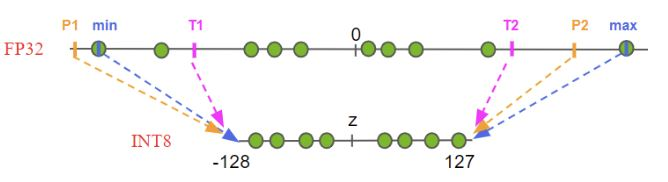

Torch-TensorRT Python API provides an easy and convenient way to use pytorch dataloaders with TensorRT calibrators.
Here we use `min-max` calibration technique

In [ ]:
calib_dataset = build_dataset("../.ncnn/calibration", name)
calib_dataset = torch.utils.data.random_split(calib_dataset, [len(calib_dataset)-200, 200])[1]
calib_dataloader = data.DataLoader(calib_dataset, batch_size=1, shuffle=False, drop_last=True)

In [ ]:
calibrator = torch_tensorrt.ptq.DataLoaderCalibrator(calib_dataloader,
                                              use_cache=False,
                                              algo_type=torch_tensorrt.ptq.CalibrationAlgo.MINMAX_CALIBRATION,
                                              device=torch.device('cuda:0'))

compile_spec = {
   "inputs": [torch_tensorrt.Input([1, 3, 224, 224])],
   "enabled_precisions": torch.int8,
   "calibrator": calibrator,
   "truncate_long_and_double": True
}
trt_ptq = torch_tensorrt.compile(traced_model, **compile_spec)

In [ ]:
test_acc = evaluate(trt_ptq, val_dataloader)
print("PTQ accuracy: {:.2f}%".format(100 * test_acc))

benchmark(trt_ptq)